# **1. Import Library**

Pada tahap ini, Anda perlu mengimpor beberapa pustaka (library) Python yang dibutuhkan untuk analisis data dan pembangunan model machine learning.

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import cross_val_score
from sklearn.decomposition import PCA
from sklearn.pipeline import Pipeline
from sklearn.naive_bayes import GaussianNB
from sklearn.preprocessing import OneHotEncoder, RobustScaler
from sklearn.metrics import accuracy_score, f1_score, classification_report, confusion_matrix, precision_score, recall_score
from sklearn.model_selection import RandomizedSearchCV
from sklearn.feature_selection import SelectKBest, f_classif, mutual_info_classif
from sklearn.model_selection import StratifiedKFold

from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier


# **2. Memuat Dataset dari Hasil Clustering**

Memuat dataset hasil clustering dari file CSV ke dalam variabel DataFrame.

In [82]:
df = pd.read_csv("hasil_clustering.csv")
df.head()

,TransactionID,AccountID,TransactionAmount,TransactionDate,DeviceID,IP Address,MerchantID,CustomerAge,TransactionDuration,LoginAttempts,AccountBalance,PreviousTransactionDate,Cluster,TransactionType,Channel,Location,CustomerOccupation
0,TX000001,AC00128,2.714032,2023-04-11 16:29:14,D000380,162.198.218.92,M015,70,81,1,5112.21,2024-11-04 08:08:08,2,Debit,ATM,San Diego,Doctor
1,TX000002,AC00455,5.932882,2023-06-27 16:44:19,D000051,13.149.61.4,M052,68,141,1,13758.91,2024-11-04 08:09:35,2,Debit,ATM,Houston,Doctor
2,TX000003,AC00019,4.846468,2023-07-10 18:16:08,D000235,215.97.143.157,M009,19,56,1,1122.35,2024-11-04 08:07:04,0,Debit,Online,Mesa,Student
3,TX000004,AC00070,5.223055,2023-05-05 16:32:11,D000187,200.13.225.150,M002,26,25,1,8569.06,2024-11-04 08:09:06,0,Debit,Online,Raleigh,Student
4,TX000005,AC00411,2.670694,2023-10-16 17:51:24,D000308,65.164.3.100,M091,26,198,1,7429.40,2024-11-04 08:06:39,1,Credit,Online,Atlanta,Student


In [83]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2512 entries, 0 to 2511
Data columns (total 17 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   TransactionID            2512 non-null   object 
 1   AccountID                2512 non-null   object 
 2   TransactionAmount        2512 non-null   float64
 3   TransactionDate          2512 non-null   object 
 4   DeviceID                 2512 non-null   object 
 5   IP Address               2512 non-null   object 
 6   MerchantID               2512 non-null   object 
 7   CustomerAge              2512 non-null   int64  
 8   TransactionDuration      2512 non-null   int64  
 9   LoginAttempts            2512 non-null   int64  
 10  AccountBalance           2512 non-null   float64
 11  PreviousTransactionDate  2512 non-null   object 
 12  Cluster                  2512 non-null   int64  
 13  TransactionType          2512 non-null   object 
 14  Channel                 

In [84]:
# Konversi TransactionDate dan PreviousTransactionDate menjadi timestamp
df['TransactionDate'] = pd.to_datetime(df['TransactionDate'])
df['TransactionDate'] = (df['TransactionDate'] - pd.Timestamp('1970-01-01')).dt.total_seconds()

df['PreviousTransactionDate'] = pd.to_datetime(df['PreviousTransactionDate'])
df['PreviousTransactionDate'] = (df['PreviousTransactionDate'] - pd.Timestamp('1970-01-01')).dt.total_seconds()

# Menampilkan tipe data terbaru untuk verifikasi
df.head()

,TransactionID,AccountID,TransactionAmount,TransactionDate,DeviceID,IP Address,MerchantID,CustomerAge,TransactionDuration,LoginAttempts,AccountBalance,PreviousTransactionDate,Cluster,TransactionType,Channel,Location,CustomerOccupation
0,TX000001,AC00128,2.714032,1.681231e+09,D000380,162.198.218.92,M015,70,81,1,5112.21,1.730708e+09,2,Debit,ATM,San Diego,Doctor
1,TX000002,AC00455,5.932882,1.687884e+09,D000051,13.149.61.4,M052,68,141,1,13758.91,1.730708e+09,2,Debit,ATM,Houston,Doctor
2,TX000003,AC00019,4.846468,1.689013e+09,D000235,215.97.143.157,M009,19,56,1,1122.35,1.730708e+09,0,Debit,Online,Mesa,Student
3,TX000004,AC00070,5.223055,1.683304e+09,D000187,200.13.225.150,M002,26,25,1,8569.06,1.730708e+09,0,Debit,Online,Raleigh,Student
4,TX000005,AC00411,2.670694,1.697479e+09,D000308,65.164.3.100,M091,26,198,1,7429.40,1.730708e+09,1,Credit,Online,Atlanta,Student


In [85]:
# Drop kolom yang tidak diperlukan
df = df.drop(columns=['TransactionID', 'AccountID', 'DeviceID', 'IP Address', 'DeviceID'])

# **3. Data Splitting**

Tahap Data Splitting bertujuan untuk memisahkan dataset menjadi dua bagian: data latih (training set) dan data uji (test set).

In [86]:
# Pisahkan fitur (X) dan label (y)
X = df.drop(columns=['Cluster'])
y = df['Cluster']

# Identifikasi kolom kategorikal dan numerikal
categorical_columns = ['TransactionType', 'Channel', 'CustomerOccupation', 'Location']
numerical_columns = [feature for feature in X.columns if feature not in categorical_columns]

# Ubah tipe data kolom numerikal dan isi nilai NaN
for col in numerical_columns:
    X[col] = pd.to_numeric(X[col], errors='coerce')  # Ubah non-numerik menjadi NaN
    X[col] = X[col].fillna(0)  # Isi nilai NaN dengan 0

# Lakukan One-Hot Encoding untuk kolom kategorikal
encoder = OneHotEncoder(drop='first', sparse_output=False)
encoded_categories = pd.DataFrame(
    encoder.fit_transform(X[categorical_columns]),
    columns=encoder.get_feature_names_out(categorical_columns)
)

# Gabungkan kolom numerikal dan kategori yang telah dienkode
prepared_data = pd.concat(
    [X[numerical_columns].reset_index(drop=True), encoded_categories.reset_index(drop=True)], axis=1
)

# Pisahkan dataset menjadi bagian training dan testing (70% training, 30% testing)
X_train, X_test, y_train, y_test = train_test_split(prepared_data, y, test_size=0.3, random_state=42)

# Standarisasi dengan RobustScaler (khusus untuk kolom numerikal)
scaler = RobustScaler()
X_train[numerical_columns] = scaler.fit_transform(X_train[numerical_columns])
X_test[numerical_columns] = scaler.transform(X_test[numerical_columns])

# Tampilkan ukuran dataset setelah pembagian
print(f"Ukuran dataset training (X_train): {X_train.shape}")
print(f"Ukuran dataset testing (X_test): {X_test.shape}")
print(f"Ukuran label training (y_train): {y_train.shape}")
print(f"Ukuran label testing (y_test): {y_test.shape}")

Ukuran dataset training (X_train): (1758, 56)
Ukuran dataset testing (X_test): (754, 56)
Ukuran label training (y_train): (1758,)
Ukuran label testing (y_test): (754,)


# **4. Membangun Model Klasifikasi**


## **a. Membangun Model Klasifikasi**

Setelah memilih algoritma klasifikasi yang sesuai, langkah selanjutnya adalah melatih model menggunakan data latih.

Berikut adalah rekomendasi tahapannya.
1. Pilih algoritma klasifikasi yang sesuai, seperti Logistic Regression, Decision Tree, Random Forest, atau K-Nearest Neighbors (KNN).
2. Latih model menggunakan data latih.

In [92]:
# Daftar model yang ingin diuji
models = {
    'Logistic Regression': LogisticRegression(C=0.1, penalty="l2", random_state=42, max_iter=1000),
    'K-Nearest Neighbors': KNeighborsClassifier(n_neighbors=5, weights="uniform"),
    'Support Vector Machine': SVC(kernel='rbf', C=1.0, gamma="auto", random_state=42),
    'Naive Bayes': GaussianNB(),
    'Random Forest': RandomForestClassifier(n_estimators=100, max_depth=5, random_state=42)
}

# Iterasi untuk setiap model
for name, model in models.items():
    # Melatih model menggunakan data training
    model.fit(X_train, y_train)
    
    # Prediksi untuk data training
    y_train_pred = model.predict(X_train)
    
    # Evaluasi performa pada data training
    print(f"\nModel {name} telah dilatih menggunakan data train.")
    print(f"Classification Report untuk data train {name}:\n")
    print(classification_report(y_train, y_train_pred, zero_division=1))
    print("-" * 50)


Model Logistic Regression telah dilatih menggunakan data train.
Classification Report untuk data train Logistic Regression:

              precision    recall  f1-score   support

           0       1.00      1.00      1.00       824
           1       1.00      1.00      1.00       403
           2       1.00      1.00      1.00       531

    accuracy                           1.00      1758
   macro avg       1.00      1.00      1.00      1758
weighted avg       1.00      1.00      1.00      1758

--------------------------------------------------

Model K-Nearest Neighbors telah dilatih menggunakan data train.
Classification Report untuk data train K-Nearest Neighbors:

              precision    recall  f1-score   support

           0       0.94      0.99      0.96       824
           1       1.00      0.89      0.94       403
           2       0.97      0.96      0.97       531

    accuracy                           0.96      1758
   macro avg       0.97      0.95      0.96 

Tulis narasi atau penjelasan algoritma yang Anda gunakan.

1. Logistic Regression: Model ini memprediksi kemungkinan hasil berdasarkan hubungan linier antara variabel input dan output. Logistic Regression menggunakan regularisasi untuk mengurangi overfitting, di mana parameter C mengontrol kekuatan regularisasi.
2. K-Nearest Neighbours (KNN): Model ini menentukan kelas berdasarkan mayoritas label dari tetangga terdekat. Jarak antara sampel dihitung menggunakan metode seperti Euclidean atau Manhattan.
3. Support Vector Machine (SVM): SVM menggunakan hyperplane untuk memisahkan kelas dengan margin maksimum. Jika data tidak bisa dipisahkan secara linier, kernel seperti RBF digunakan untuk menangani pola non-linear.
4. Naive Bayes: Naive Bayes menghitung probabilitas setiap kelas berdasarkan fitur, dengan asumsi bahwa fitur saling independen. Gaussian Naive Bayes cocok untuk data numerik yang mengikuti distribusi normal.
5. Random Forest: Random Forest membangun banyak pohon keputusan independen, dan hasil akhirnya berdasarkan suara mayoritas dari semua pohon. Model ini tahan terhadap overfitting dengan pengaturan seperti jumlah pohon (n_estimators) dan kedalaman maksimal (max_depth). 


**Insights:**
- Logistic Regression, SVM, Random Forest, dan Decision Tree sangat mungkin mengalami overfitting, karena performanya yang terlalu sempurna di data training
- KNN menunjukkan hasil lebih realistis, tetapi performanya tetap perlu diuji pada data testing untuk memastikan generalisasi
- Naive Bayes cenderung lebih sederhana, dan meskipun hampir sempurna, algoritma ini biasanya tidak rentan overfitting sebesar model yang lebih kompleks

## **b. Evaluasi Model Klasifikasi**

Berikut adalah **rekomendasi** tahapannya.
1. Lakukan prediksi menggunakan data uji.
2. Hitung metrik evaluasi seperti Accuracy dan F1-Score (Opsional: Precision dan Recall).
3. Buat confusion matrix untuk melihat detail prediksi benar dan salah.

== Logistic Regression ==
Logistic Regression Accuracy: 1.0000
Logistic Regression F1-Score: 1.0000
Logistic Regression Precision: 1.0000
Logistic Regression Recall: 1.0000

Classification Report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00       360
           1       1.00      1.00      1.00       165
           2       1.00      1.00      1.00       229

    accuracy                           1.00       754
   macro avg       1.00      1.00      1.00       754
weighted avg       1.00      1.00      1.00       754

--------------------------------------------------


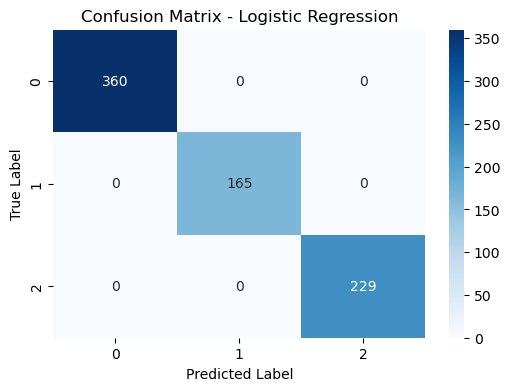

== K-Nearest Neighbors ==
K-Nearest Neighbors Accuracy: 0.9297
K-Nearest Neighbors F1-Score: 0.9292
K-Nearest Neighbors Precision: 0.9327
K-Nearest Neighbors Recall: 0.9297

Classification Report:
               precision    recall  f1-score   support

           0       0.91      0.97      0.94       360
           1       0.99      0.84      0.91       165
           2       0.93      0.93      0.93       229

    accuracy                           0.93       754
   macro avg       0.94      0.91      0.93       754
weighted avg       0.93      0.93      0.93       754

--------------------------------------------------


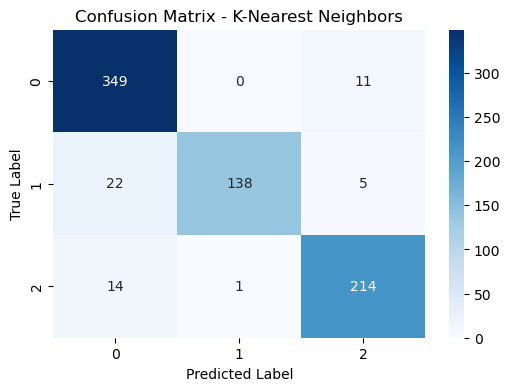

== Support Vector Machine ==
Support Vector Machine Accuracy: 1.0000
Support Vector Machine F1-Score: 1.0000
Support Vector Machine Precision: 1.0000
Support Vector Machine Recall: 1.0000

Classification Report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00       360
           1       1.00      1.00      1.00       165
           2       1.00      1.00      1.00       229

    accuracy                           1.00       754
   macro avg       1.00      1.00      1.00       754
weighted avg       1.00      1.00      1.00       754

--------------------------------------------------


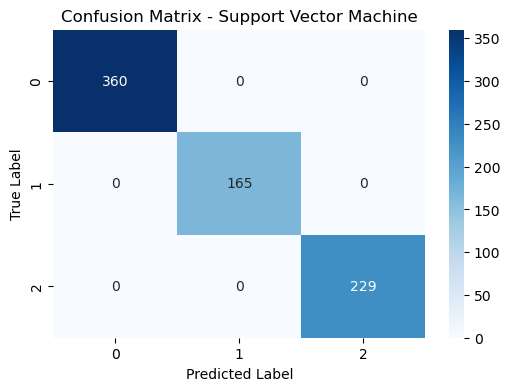

== Naive Bayes ==
Naive Bayes Accuracy: 0.9814
Naive Bayes F1-Score: 0.9813
Naive Bayes Precision: 0.9821
Naive Bayes Recall: 0.9814

Classification Report:
               precision    recall  f1-score   support

           0       0.96      1.00      0.98       360
           1       1.00      1.00      1.00       165
           2       1.00      0.94      0.97       229

    accuracy                           0.98       754
   macro avg       0.99      0.98      0.98       754
weighted avg       0.98      0.98      0.98       754

--------------------------------------------------


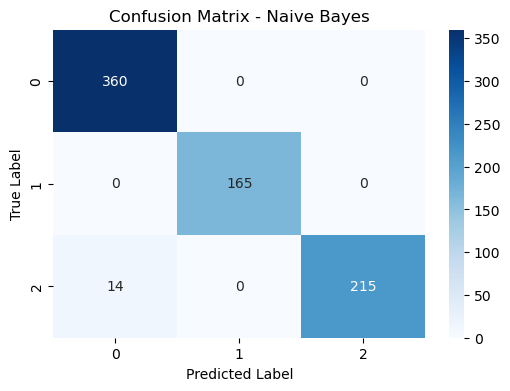

== Random Forest ==
Random Forest Accuracy: 0.9960
Random Forest F1-Score: 0.9960
Random Forest Precision: 0.9961
Random Forest Recall: 0.9960

Classification Report:
               precision    recall  f1-score   support

           0       0.99      1.00      1.00       360
           1       1.00      1.00      1.00       165
           2       1.00      0.99      0.99       229

    accuracy                           1.00       754
   macro avg       1.00      1.00      1.00       754
weighted avg       1.00      1.00      1.00       754

--------------------------------------------------


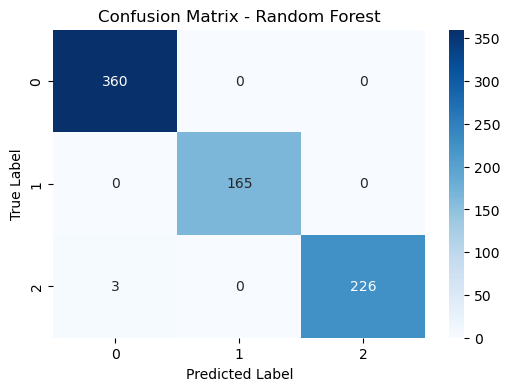

In [93]:
# Iterasi untuk setiap model
for name, model in models.items():
    # Prediksi menggunakan data testing
    y_pred = model.predict(X_test)
    
    # Hitung metrik evaluasi
    accuracy = accuracy_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred, average='weighted')
    precision = precision_score(y_test, y_pred, average='weighted')
    recall = recall_score(y_test, y_pred, average='weighted')
    
    # Print hasil evaluasi
    print(f"== {name} ==")
    print(f"{name} Accuracy: {accuracy:.4f}")
    print(f"{name} F1-Score: {f1:.4f}")
    print(f"{name} Precision: {precision:.4f}")
    print(f"{name} Recall: {recall:.4f}")
    print("\nClassification Report:\n", classification_report(y_test, y_pred, zero_division=1))
    print("-" * 50)
    
    # Confusion Matrix
    plt.figure(figsize=(6,4))
    sns.heatmap(confusion_matrix(y_test, y_pred), annot=True, fmt="d", cmap="Blues", 
                xticklabels=set(y_test), yticklabels=set(y_test))
    plt.xlabel("Predicted Label")
    plt.ylabel("True Label")
    plt.title(f"Confusion Matrix - {name}")
    plt.show()

In [94]:
# Buat list untuk menyimpan hasil evaluasi
evaluation_results = []

# Evaluasi setiap model
for name, model in models.items():
    # Prediksi pada data testing
    y_test_pred = model.predict(X_test)
    
    # Hitung metrik evaluasi
    acc = accuracy_score(y_test, y_test_pred)
    prec = precision_score(y_test, y_test_pred, average='weighted', zero_division=1)
    rec = recall_score(y_test, y_test_pred, average='weighted')
    f1 = f1_score(y_test, y_test_pred, average='weighted')
    
    # Tambahkan hasil evaluasi ke list
    evaluation_results.append({"Model": name, "Accuracy": acc, "Precision": prec, "Recall": rec, "F1-Score": f1})

# Konversi hasil evaluasi ke DataFrame
results_df = pd.DataFrame(evaluation_results)

# Tampilkan hasil evaluasi
print("Hasil Evaluasi Model:")
print(results_df)

Hasil Evaluasi Model:
                    Model  Accuracy  Precision    Recall  F1-Score
0     Logistic Regression  1.000000   1.000000  1.000000  1.000000
1     K-Nearest Neighbors  0.929708   0.932653  0.929708  0.929211
2  Support Vector Machine  1.000000   1.000000  1.000000  1.000000
3             Naive Bayes  0.981432   0.982127  0.981432  0.981317
4           Random Forest  0.996021   0.996054  0.996021  0.996016


Tulis hasil evaluasi algoritma yang digunakan, jika Anda menggunakan 2 algoritma, maka bandingkan hasilnya.

1. Logistic Regression
    - Hasil sempurna dengan semua metrik bernilai 1 menunjukkan bahwa model sangat akurat dalam memprediksi data testing
    - Kemungkinan model bekerja baik karena fitur dan target memiliki hubungan linier yang sangat kuat. Namun, hasil sempurna perlu diuji lebih lanjut pada dataset yang berbeda untuk memastikan kemampuan generalisasi
2. KNN
    - KNN menunjukkan hasil yang baik dengan akurasi mendekati 93%
    - Precision, recall, dan F1-score cukup konsisten di semua metrik, menunjukkan bahwa model dapat memprediksi kelas dengan baik
    - Penurunan performa pada kelas minoritas terlihat pada recall untuk beberapa kelas, seperti kelas 1, di mana recall hanya mencapai 84%. Meskipun demikian, precision untuk kelas tersebut sangat tinggi (99%), menunjukkan bahwa model cukup akurat dalam memberikan prediksi positif untuk kelas ini
3. SVM
    - Hasil sempurna seperti Logistic Regression, dengan semua metrik bernilai 1
    - Performa ini menunjukkan bahwa data testing sangat mudah dipisahkan dengan margin maksimal, kemungkinan karena pola antar kelas cukup jelas
4. Naive Bayes
    - Naive Bayes menunjukkan performa yang lebih unggul dibandingkan KNN, dengan akurasi hampir mencapai 98%
    - Precision dan recall sangat tinggi untuk sebagian besar kelas, termasuk kelas minoritas, dengan recall sempurna (100%) pada kelas 1. Namun, recall sedikit menurun untuk kelas 2 (94%), yang berarti model kehilangan sebagian kecil dari sampel di kelas tersebut
5. Random Forest
    - Dengan akurasi 99.60%, model ini menunjukkan hasil yang hampir sempurna dengan konsistensi di semua metrik
    - Random Forest menggunakan ensemble decision trees, sehingga model lebih tahan terhadap kesalahan dibandingkan Decision Tree individual

## **c. Tuning Model Klasifikasi (Optional)**

Gunakan GridSearchCV, RandomizedSearchCV, atau metode lainnya untuk mencari kombinasi hyperparameter terbaik

In [97]:
# Dictionary untuk menyimpan parameter grid masing-masing model
param_grids = {
    "Logistic Regression": {
        'C': [0.01, 0.1, 1, 10],  # Regularisasi
        'penalty': ['l1', 'l2'],  # Jenis regularisasi
        'solver': ['liblinear', 'saga']  # Solver yang mendukung l1 dan l2
    },
    "Support Vector Machine": {
        'C': [0.1, 1, 10],  # Regularisasi
        'kernel': ['linear', 'rbf'],  # Kernel
        'gamma': ['scale', 'auto']  # Parameter gamma
    },
    "K-Nearest Neighbors": {
        'n_neighbors': [3, 5, 7, 9, 11],  # Jumlah tetangga
        'weights': ['uniform', 'distance'],  # Bobot
        'metric': ['euclidean', 'manhattan', 'minkowski']  # Metode jarak
    },
    "Naive Bayes": {
        # Tidak ada hyperparameter eksplisit untuk GaussianNB di scikit-learn
    },
    "Random Forest": {
        'n_estimators': [100, 200, 300],  # Jumlah pohon
        'max_depth': [None, 10, 20],  # Kedalaman maksimum
        'min_samples_split': [2, 5, 10]  # Minimum sampel untuk split
    },
}
# Tuning hyperparameter untuk setiap model
best_params = {}
for name, param_grid in param_grids.items():
    if param_grid:  # Hanya model dengan parameter grid
        print(f"Tuning hyperparameter untuk {name}...")
        
        # GridSearchCV untuk model
        grid_search = GridSearchCV(models[name], param_grid, cv=5, scoring='accuracy', n_jobs=-1)
        grid_search.fit(X_train, y_train)
        
        # Simpan hyperparameter terbaik
        best_params[name] = grid_search.best_params_
        print(f"Best Parameters for {name}: {grid_search.best_params_}")
    else:
        print(f"Tidak ada parameter yang di-tuning untuk {name}.")

# Tampilkan semua parameter terbaik
print("\nHyperparameter terbaik untuk semua model:")
for model_name, params in best_params.items():
    print(f"{model_name}: {params}")

Tuning hyperparameter untuk Logistic Regression...
Best Parameters for Logistic Regression: {'C': 0.01, 'penalty': 'l1', 'solver': 'saga'}
Tuning hyperparameter untuk Support Vector Machine...
Best Parameters for Support Vector Machine: {'C': 0.1, 'gamma': 'scale', 'kernel': 'linear'}
Tuning hyperparameter untuk K-Nearest Neighbors...
Best Parameters for K-Nearest Neighbors: {'metric': 'manhattan', 'n_neighbors': 11, 'weights': 'distance'}
Tidak ada parameter yang di-tuning untuk Naive Bayes.
Tuning hyperparameter untuk Random Forest...
Best Parameters for Random Forest: {'max_depth': None, 'min_samples_split': 2, 'n_estimators': 100}

Hyperparameter terbaik untuk semua model:
Logistic Regression: {'C': 0.01, 'penalty': 'l1', 'solver': 'saga'}
Support Vector Machine: {'C': 0.1, 'gamma': 'scale', 'kernel': 'linear'}
K-Nearest Neighbors: {'metric': 'manhattan', 'n_neighbors': 11, 'weights': 'distance'}
Random Forest: {'max_depth': None, 'min_samples_split': 2, 'n_estimators': 100}


## **d. Evaluasi Model Klasifikasi setelah Tuning (Optional)**

Berikut adalah rekomendasi tahapannya.
1. Gunakan model dengan hyperparameter terbaik.
2. Hitung ulang metrik evaluasi untuk melihat apakah ada peningkatan performa.


Evaluasi Logistic Regression setelah tuning:
Accuracy: 1.0000
Precision: 1.0000
Recall: 1.0000
F1-Score: 1.0000

Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       360
           1       1.00      1.00      1.00       165
           2       1.00      1.00      1.00       229

    accuracy                           1.00       754
   macro avg       1.00      1.00      1.00       754
weighted avg       1.00      1.00      1.00       754



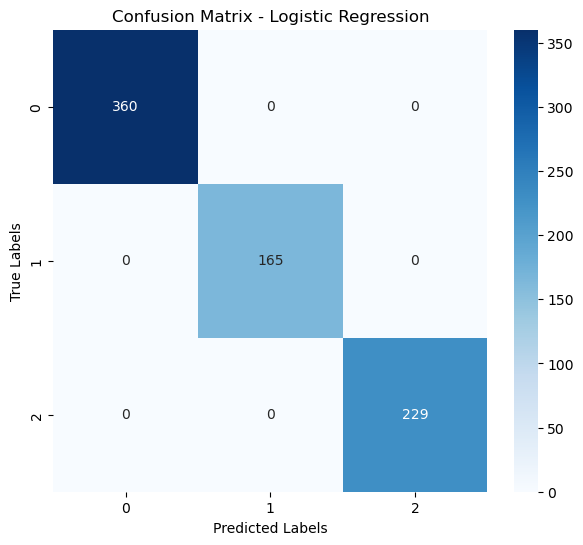


Evaluasi K-Nearest Neighbors setelah tuning:
Accuracy: 0.9775
Precision: 0.9779
Recall: 0.9775
F1-Score: 0.9773

Classification Report:
              precision    recall  f1-score   support

           0       0.97      0.99      0.98       360
           1       1.00      0.92      0.96       165
           2       0.97      0.99      0.98       229

    accuracy                           0.98       754
   macro avg       0.98      0.97      0.97       754
weighted avg       0.98      0.98      0.98       754



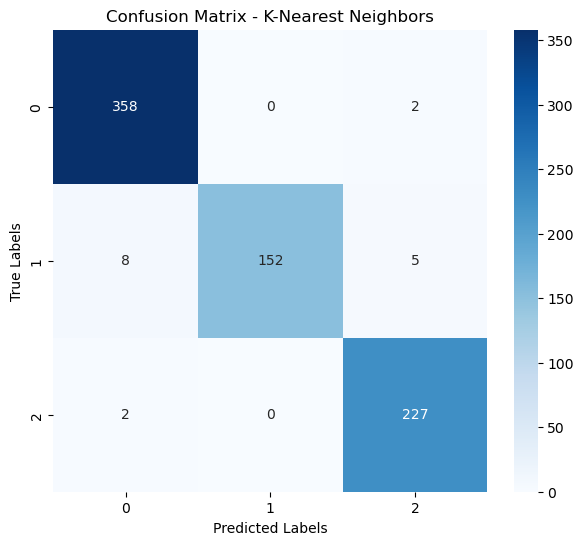


Evaluasi Support Vector Machine setelah tuning:
Accuracy: 1.0000
Precision: 1.0000
Recall: 1.0000
F1-Score: 1.0000

Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       360
           1       1.00      1.00      1.00       165
           2       1.00      1.00      1.00       229

    accuracy                           1.00       754
   macro avg       1.00      1.00      1.00       754
weighted avg       1.00      1.00      1.00       754



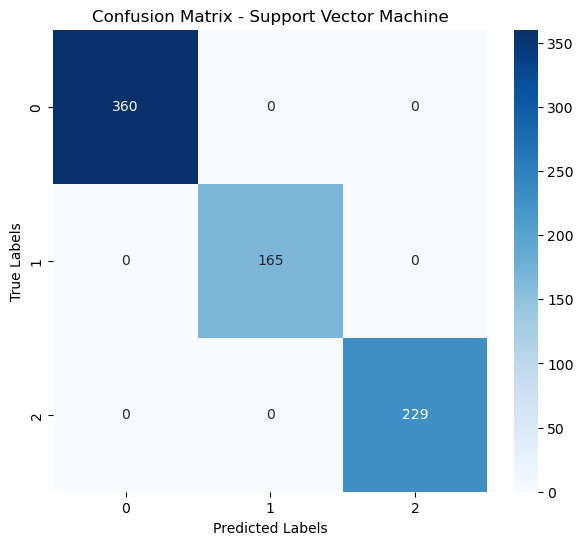


Evaluasi Random Forest setelah tuning:
Accuracy: 1.0000
Precision: 1.0000
Recall: 1.0000
F1-Score: 1.0000

Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       360
           1       1.00      1.00      1.00       165
           2       1.00      1.00      1.00       229

    accuracy                           1.00       754
   macro avg       1.00      1.00      1.00       754
weighted avg       1.00      1.00      1.00       754



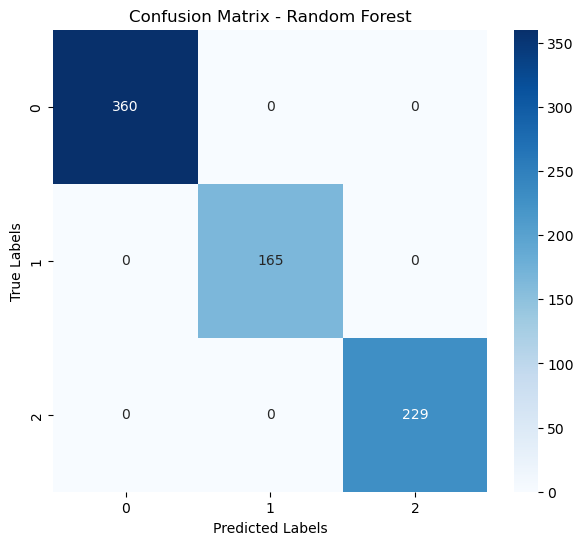

In [98]:
# Evaluasi model setelah tuning
def evaluate_model(y_true, y_pred, model_name):
    print(f"\nEvaluasi {model_name} setelah tuning:")
    print(f"Accuracy: {accuracy_score(y_true, y_pred):.4f}")
    print(f"Precision: {precision_score(y_true, y_pred, average='weighted', zero_division=1):.4f}")
    print(f"Recall: {recall_score(y_true, y_pred, average='weighted'):.4f}")
    print(f"F1-Score: {f1_score(y_true, y_pred, average='weighted'):.4f}")
    print("\nClassification Report:")
    print(classification_report(y_true, y_pred, zero_division=1))

# Visualisasi confusion matrix
def plot_confusion_matrix(y_true, y_pred, model_name):
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(7, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=set(y_true), yticklabels=set(y_true))
    plt.title(f"Confusion Matrix - {model_name}")
    plt.xlabel("Predicted Labels")
    plt.ylabel("True Labels")
    plt.show()

# Evaluasi semua model terbaik setelah tuning
for name, model in models.items():
    if name in best_params:  # Pastikan model memiliki parameter tuning
        # Ambil model terbaik dari GridSearchCV
        tuned_model = model.set_params(**best_params[name])
        tuned_model.fit(X_train, y_train)

        # Prediksi ulang menggunakan model terbaik
        y_test_pred = tuned_model.predict(X_test)

        # Evaluasi performa model
        evaluate_model(y_test, y_test_pred, name)

        # Visualisasi confusion matrix
        plot_confusion_matrix(y_test, y_test_pred, name)

## **e. Analisis Hasil Evaluasi Model Klasifikasi**

Berikut adalah **rekomendasi** tahapannya.
1. Bandingkan hasil evaluasi sebelum dan setelah tuning (jika dilakukan).
2. Identifikasi kelemahan model, seperti:
  - Precision atau Recall rendah untuk kelas tertentu.
  - Apakah model mengalami overfitting atau underfitting?
3. Berikan rekomendasi tindakan lanjutan, seperti mengumpulkan data tambahan atau mencoba algoritma lain jika hasil belum memuaskan.

### Analisis Performa Model Sebelum dan Sesudah Tuning

Berdasarkan evaluasi sebelum dan setelah tuning, kita dapat melihat bagaimana perubahan parameter memengaruhi performa model. Berikut adalah analisis dan rekomendasi untuk masing-masing model:

1. Logistic Regression
    - Sebelumm Tuning
        - Akurasi: 100%
        - Presisi: 100%
        - Recall: 100%
        - F1-Score: 100%
    - Sesudah Tuning
        - Akurasi: 100%
        - Presisi: 100%
        - Recall: 100%
        - F1-Score: 100%
    - Analisis: 
        - Tuning tidak memberikan dampak pada model ini, kemungkinan karena parameter default sudah optimal untuk dataset yang memiliki hubungan linier yang sangat kuat antara fitur dan target
        - Tidak ada indikasi overfitting pada data testing, namun hasil sempurna ini perlu diuji lebih lanjut dengan dataset eksternal untuk memastikan kemampuan generalisasi

2. K-Nearest Neighbours (KNN)
    - Sebelum Tuning
        - Akurasi: 92,97%
        - Presisi: 93,26%
        - Recall: 92,97%
        - F1-Score: 92,92%
    - Sesudah Tuning
        - Akurasi: 97,75%
        - Presisi: 97,79%
        - Recall: 97,75%
        - F1-Score: 97,73%
    - Analisis:
        - Tuning hyperparameter memberikan peningkatan yang signifikan pada semua metrik. Akurasi meningkat dari 92.97% menjadi 97.75%
        - Peningkatan ini menunjukkan bahwa parameter optimal seperti jumlah tetangga (n_neighbors), bobot (weights), dan metode jarak (metric) berhasil memperbaiki performa model

3. Support Vector Machine (VSM)
    - Sebelum Tuning
        - Akurasi: 100%
        - Presisi: 100%
        - Recall: 100%
        - F1-Score: 100%
    - Sesudah Tuning
        - Akurasi: 100%
        - Presisi: 100%
        - Recall: 100%
        - F1-Score: 100%
    - Analisis:
        - Tuning tidak memberikan dampak pada performa. Parameter default seperti kernel dan regulasi (C) mungkin sudah sangat sesuai dengan dataset ini
        - Hasil sempurna menunjukkan bahwa dataset testing memiliki pola yang sangat mudah dipisahkan oleh SVM dengan margin maksimum. Validasi lebih lanjut dengan dataset baru diperlukan untuk memastikan generalisasi

4. Naive Bayes
    - Sebelum Tuning
        - Akurasi: 98,14%
        - Presisi: 98,21%
        - Recall: 98,14%
        - F1-Score: 98,13%
    - Sesudah Tuning: -
    - Analisis:
        - Karena tuning Naive Bayes (GaussianNB) tidak dilakukan atau tidak relevan (karena tidak ada parameter yang dioptimalkan untuk GaussianNB), hasil tetap seperti sebelum tuning. Naive Bayes sudah cukup baik dalam menangkap pola dataset tanpa overfitting

5. Random Forest
    - Sebelum Tuning
        - Akurasi: 99,6%
        - Presisi: 99,61%
        - Recall: 99,6%
        - F1-Score: 99,6%
    - Sesudah Tuning: 
        - Akurasi: 100%
        - Presisi: 100%
        - Recall: 100%
        - F1-Score: 100%
    - Analisis:
        - Tuning memberikan peningkatan dari 99.60% menjadi hasil sempurna 100.00%
        - Parameter seperti jumlah pohon (n_estimators), kedalaman maksimum (max_depth), dan minimum sampel split (min_samples_split) membantu model menangkap pola dataset dengan lebih baik
        - Hasil sempurna ini, meskipun impresif, memerlukan validasi lebih lanjut untuk memastikan generalisasi.


### Rekomendasi Tindakan Lanjutan
1. Hasil sempurna perlu diuji dengan dataset eksternal atau lebih kompleks untuk memahami kemampuan generalisasi model Logistic Regression, SVM, Decision Tree, dan Random Forest
2. Setelah tuning, KNN menunjukkan performa yang sangat baik dengan hasil realistis. Model ini dapat dipertimbangkan untuk masalah dengan risiko overfitting yang rendah
3. Jika dataset lebih kompleks, lakukan tuning lebih lanjut untuk Random Forest dengan fokus pada pengurangan kedalaman pohon (max_depth) guna menghindari kemungkinan overfitting
4. Untuk meningkatkan performa, kombinasi beberapa model terbaik (ensembling) seperti Random Forest dengan Logistic Regression atau SVM dapat dipertimbangkan